# Introduction

Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.

Similar to what us humans do all the time by default, when are looking then whatever we are seeing if we think of that as an image then we know what class each pixel of the image belongs to.

Essentially, Semantic Segmentation is the technique through which we can achieve this in Computers.

Applications:

1. Autonomous driving
2. Facial segmentation
3. Geo land sensing
4. Indoor outdoor segmentation

For the image data, I will use the following metrics

mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]

# FCN with Resnet101 architecture

In [1]:
from torchvision import models
from PIL import Image
import torchvision
import os
import subprocess
import matplotlib.pyplot as plt
import torch
import requests
import time

plt.style.use('ggplot')

In [2]:
# load fcn resnet 101
fcn = models.segmentation.fcn_resnet101(
    weights = torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT
).eval()

we have a pretrained fcn with resnet101 architecture

In [3]:
# Helper function to download file.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        subprocess.run(['wget', url, '-O', save_name, '-q'])

In [4]:
# Create directory to store inference data
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

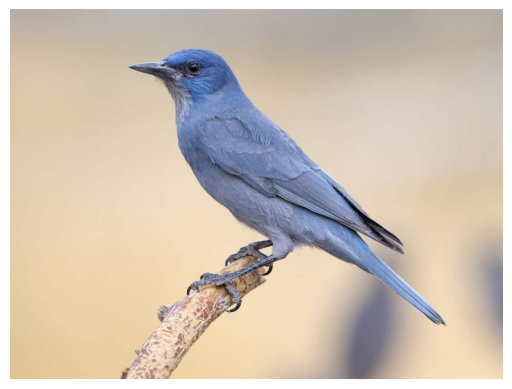

In [5]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/bird.jpg',
    save_name=os.path.join(inference_dir, 'bird.jpg')
)

img = Image.open(os.path.join(inference_dir, 'bird.jpg'))
plt.imshow(img)
plt.axis(False)
plt.show()

In [6]:
# preprocess and normalize the image

import torchvision.transforms as T
trf = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
inp = trf(img).unsqueeze(0)

In [7]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


Alright! So, out is the final output of the model. And as we can see, its shape is [1 x 21 x H x W] as discussed earlier. So, the model was trained on 21 classes and thus our output have 21 channels!

Now, what we need to do is make this 21 channeled output into a 2D image or a 1 channeled image, where each pixel of that image corresponds to a class!

So, the 2D image, (of shape [H x W]) will have each pixel corresponding to a class label, and thus
for each (x, y) in this 2D image will correspond to a number between 0 - 20 representing a class.

And how do we get there from this [1 x 21 x H x W]?
We take a max index for each pixel position, which represents the class

In [8]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


Alright! So, we as we can see now have a 2D image. Where each pixel corresponds to a class! The last thing is to take this 2D image where each pixel corresponds to a class label and convert this
into a segmentation map where each class label is converted into a RGB color and thus helping in easy visualization.

We will use the following function to convert this 2D image to an RGB image wheree each label is mapped to its corresponding color.

In [9]:
def decode_segmap(image, channels = 21):

    label_colors = np.array([(0, 0, 0),  # 0=background
            # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
            (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
            # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
            (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
            # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
            (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
            # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
            (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    red = np.zeros_like(image).astype(np.uint8)
    green = np.zeros_like(image).astype(np.uint8)
    blue = np.zeros_like(image).astype(np.uint8)

    for label in range(0, channels):
        idx = image == label
        red[idx] = label_colors[label, 0]
        green[idx] = label_colors[label, 1]
        blue[idx] = label_colors[label, 2]

    rgb = np.stack([red, green, blue], axis=2)
    return rgb

first label_colors stores the colors for each of the clases, according to the index So, the color for the first class which is background is stored in the 0th index of the label_colors list, the second class which is aeroplane is stored at index 1 of label_colors.

Now, we are to create an RGB image from the 2D image passed. So, what we do, is we create empty 2D matrices for all 3 channels.

So, red, green, and blue are arrays which will form the RGB channels for the final image. And each are of shape [H x W] (which is same as the shape of image passed in)

Now, we loop over each class color we stored in label_colors. And we get the indexes in the image where that particular class label is present. (idx = image == label) And then for each channel, we put its corresponding color to those pixels where that class label is present.

And finally we stack the 3 seperate channels to form a RGB image.

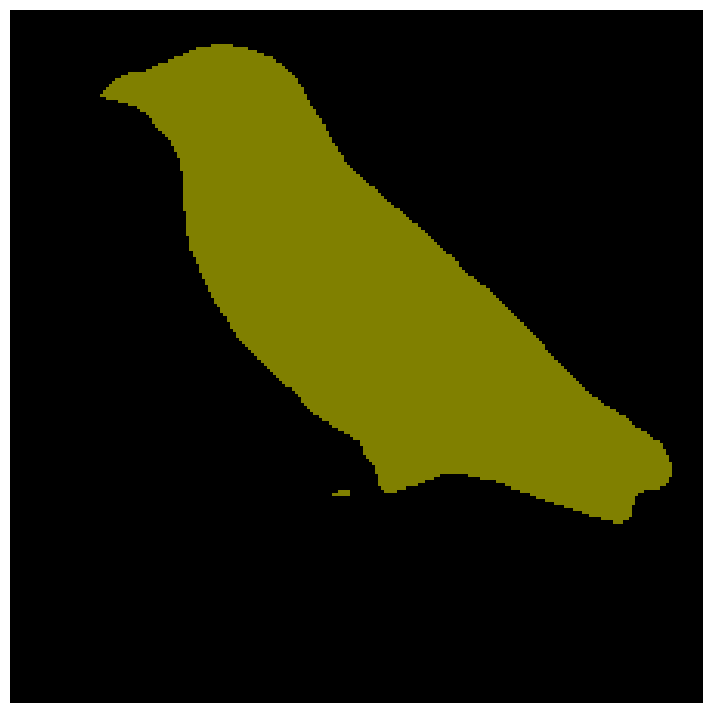

In [10]:
# segmented rgb output

rgb = decode_segmap(om)
plt.figure(figsize=(12, 9))
plt.imshow(rgb)
plt.axis('off')
plt.show()

In [11]:
def segment(net, path, show_orig = True, device = 'cuda'):

    plt.figure(figsize=(10,6))
    img = Image.open(path)
    if show_orig:
        plt.imshow(img)
        plt.axis(False)
        plt.show()

    trf = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    inp = trf(img).unsqueeze(0).to(device)
    out = net.to(device)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.figure(figsize=(10,6))
    plt.imshow(rgb)
    plt.axis(False)
    plt.show()

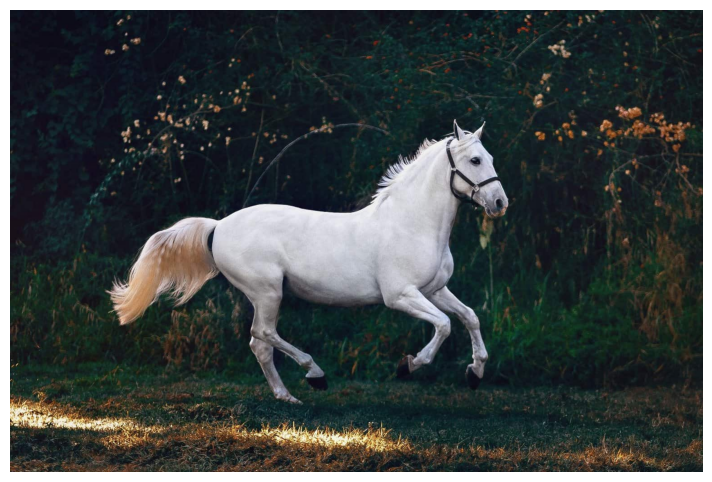

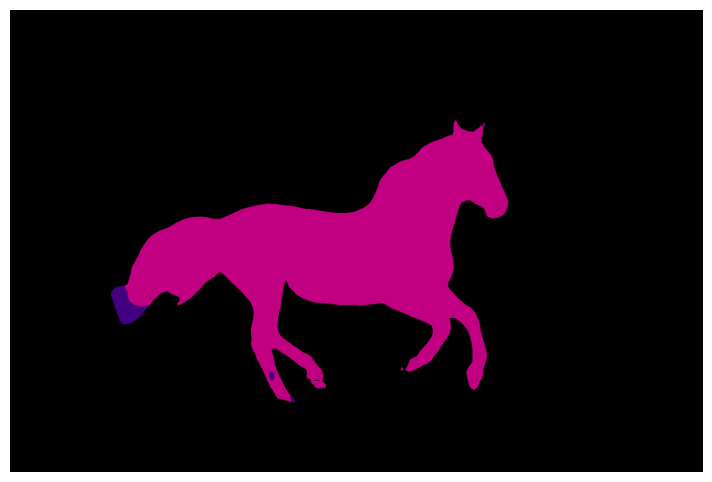

In [12]:
download_file(
    'https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg',
     save_name=os.path.join(inference_dir, 'horse.jpg')
)
segment(fcn, os.path.join(inference_dir, 'horse.jpg'))

# DeepLabv3

In [13]:
dlab = models.segmentation.deeplabv3_resnet101(
    weights='COCO_WITH_VOC_LABELS_V1',
    pretrained=True
).eval()

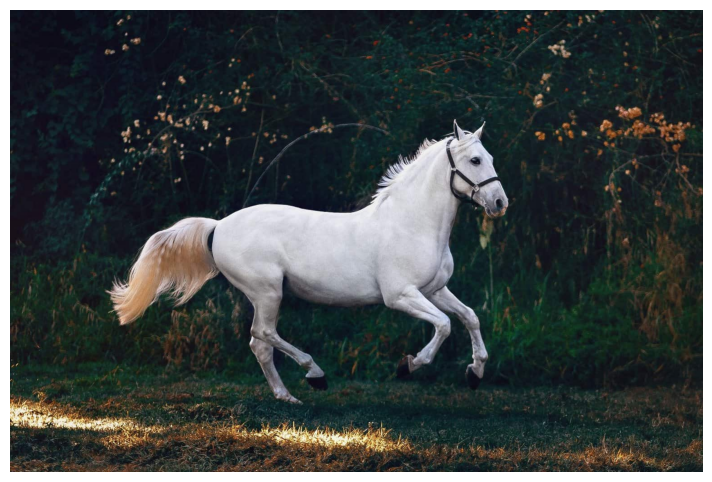

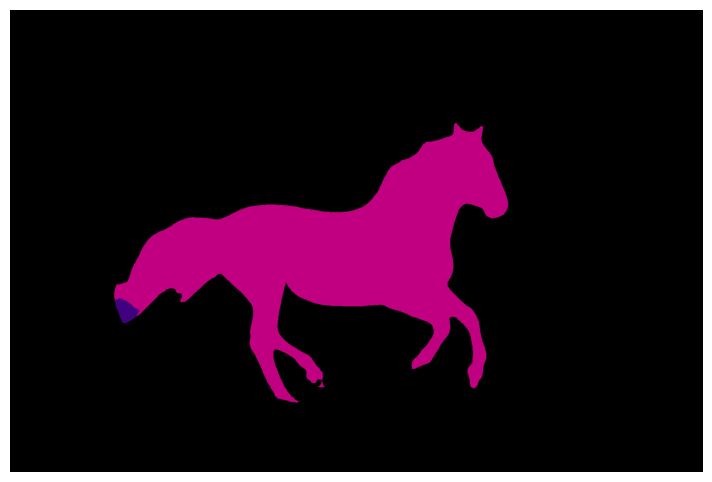

In [14]:
segment(dlab, os.path.join(inference_dir, 'horse.jpg'))

# FCN v DeepLabv3

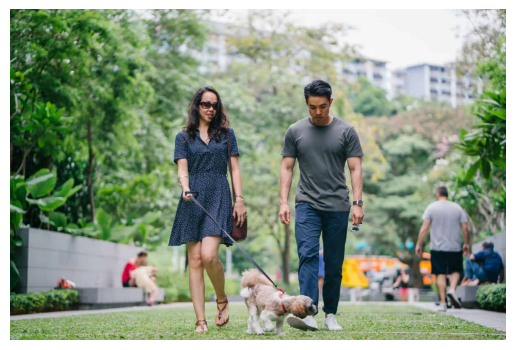

Segmenatation Image on FCN


<Figure size 1000x600 with 0 Axes>

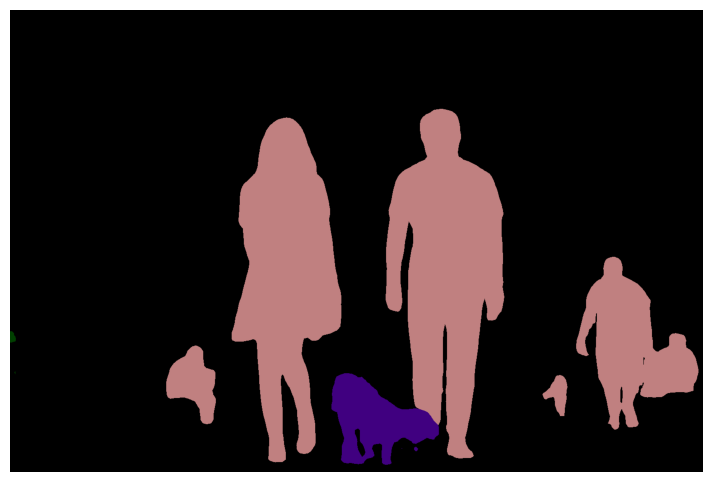

Segmenatation Image on DeepLabv3


<Figure size 1000x600 with 0 Axes>

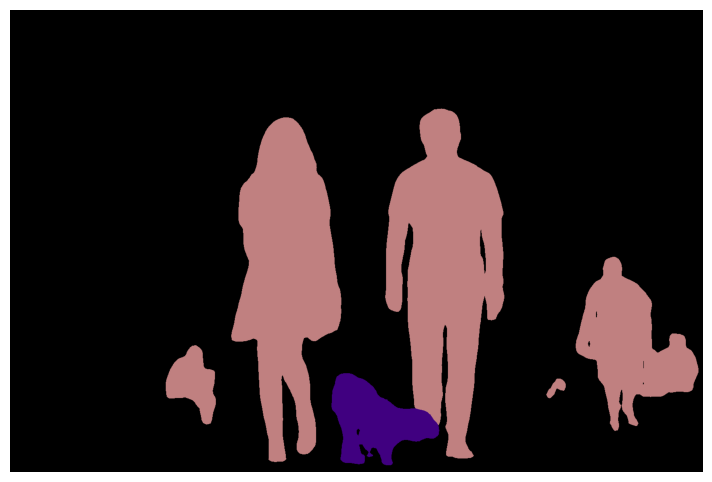

In [15]:
download_file(
    'https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg',
    save_name=os.path.join(inference_dir, 'person.jpg')
)
img = Image.open(os.path.join(inference_dir, 'person.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path=os.path.join(inference_dir, 'person.jpg'), show_orig=False)

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path=os.path.join(inference_dir, 'person.jpg'), show_orig=False)